# Visualize Probed Activations — CLIP Vision Encoder Example

This script demonstrates how to **visualize** intermediate activations
probed from a pretrained CLIP vision encoder (image encoder). It mirrors
the text-encoder example in `visualize_activations_example.py` but
operates on image patch tokens instead of text tokens.

CLIP's vision encoder is a ViT (Vision Transformer) that splits an
input image into non-overlapping patches, projects them to embeddings,
prepends a `[CLS]` token, and processes the sequence through
transformer blocks.

Each block has the following structure:

```
    CLIPEncoderLayer
    ├── self_attn          (CLIPAttention)
    │   ├── q_proj         (Linear — query projection)
    │   ├── k_proj         (Linear — key projection)
    │   ├── v_proj         (Linear — value projection)
    │   └── out_proj       (Linear — output projection)
    ├── layer_norm1        (LayerNorm)
    ├── mlp                (CLIPMLP)
    │   ├── fc1            (Linear — FFN up-projection)
    │   ├── activation_fn  (QuickGELU)
    │   └── fc2            (Linear — FFN down-projection)
    └── layer_norm2        (LayerNorm)
```

The layer-ID notation for the `clip_vision` config::

```
    "L0"                  → full block output
    "L0.attn"             → self-attention output
    "L0.attn.q_proj"      → query projection
    "L0.attn.k_proj"      → key projection
    "L0.attn.v_proj"      → value projection
    "L0.attn.out_proj"    → attention output projection
    "L0.mlp"              → full MLP output
    "L0.mlp.fc1"          → FFN up-projection (activation fn INPUT)
    "L0.mlp.activation_fn"→ QuickGELU output  (activation fn OUTPUT)
    "L0.mlp.fc2"          → FFN down-projection
    "L0.output"           → layer_norm2
```

Prerequisites:
```
pip install captum transformers matplotlib pillow
```

Usage:
```
python examples/visualize_vision_activations_example.py
```

The script saves the figures to PNG files in the current directory.

Note:
Attention weight extraction requires `output_attentions=True` and `attn_implementation="eager"` in the model config.

In [1]:
import torch
from transformers import CLIPImageProcessor, CLIPVisionModel

from captum._utils.transformer.accessor import ActivationAccessor
from captum._utils.transformer.visualization import (
    visualize_activation_distribution,
    visualize_activation_stats,
    visualize_activations,
    visualize_attention_heads,
)

/home/xzhou185/Documents/XAI-kit/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load pretrained CLIP vision encoder
Use `attn_implementation="eager"` so attention weights are returned.

In [2]:
torch.manual_seed(42)

In [3]:
model_name = "openai/clip-vit-base-patch32"
print(f"Loading {model_name} (vision encoder only)...")
processor = CLIPImageProcessor.from_pretrained(model_name)
model = CLIPVisionModel.from_pretrained(
    model_name, attn_implementation="eager"
)
model.eval()
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
hidden_dim = model.config.hidden_size
patch_size = model.config.patch_size
image_size = model.config.image_size
num_patches = (image_size // patch_size) ** 2
print(
    f"  Vision encoder: {num_layers} layers, {num_heads} heads, "
    f"d={hidden_dim}"
)
print(
    f"  Image {image_size}×{image_size}, patch {patch_size}×{patch_size} "
    f"→ {num_patches} patches + 1 [CLS] = {num_patches + 1} tokens"
)

Loading openai/clip-vit-base-patch32 (vision encoder only)...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1189.82it/s, Materializing param=vision_model.pre_layrnorm.weight]                        
CLIPVisionModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.encoder.layers.{0...11}.mlp.fc2.weight            | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.v_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.weight        | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
text_model.final_layer_norm.weight                           | UNEXPEC

  Vision encoder: 12 layers, 12 heads, d=768
  Image 224×224, patch 32×32 → 49 patches + 1 [CLS] = 50 tokens


## 2. Create a synthetic input image (random RGB)
In practice, replace this with a real image:
``` python
from PIL import Image
image = Image.open("photo.jpg")
inputs = processor(images=image, return_tensors="pt")
```

In [4]:
from PIL import Image

image_data = torch.randint(
    0, 256, (image_size, image_size, 3), dtype=torch.uint8
).numpy()
image = Image.fromarray(image_data)
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs["pixel_values"]
print(f"Input image shape: {pixel_values.shape}")  # (1, 3, 224, 224)

# Token labels: [CLS] + patch indices
patch_labels = ["[CLS]"] + [f"p{i}" for i in range(num_patches)]
print(f"Tokens ({len(patch_labels)}): {patch_labels[:5]} ... {patch_labels[-3:]}")

Input image shape: torch.Size([1, 3, 224, 224])
Tokens (50): ['[CLS]', 'p0', 'p1', 'p2', 'p3'] ... ['p46', 'p47', 'p48']


# 3. Create accessor using the "clip_vision" architecture config
This maps: L<i> → vision_model.encoder.layers.<i>

In [5]:
accessor = ActivationAccessor(model, "clip_vision")

# 4. Visualization 1: FFN internals heatmap (block 0)
fc1 (up-projection) → activation_fn (QuickGELU) → fc2 (down)

Generating FFN activation heatmaps (block 0)...


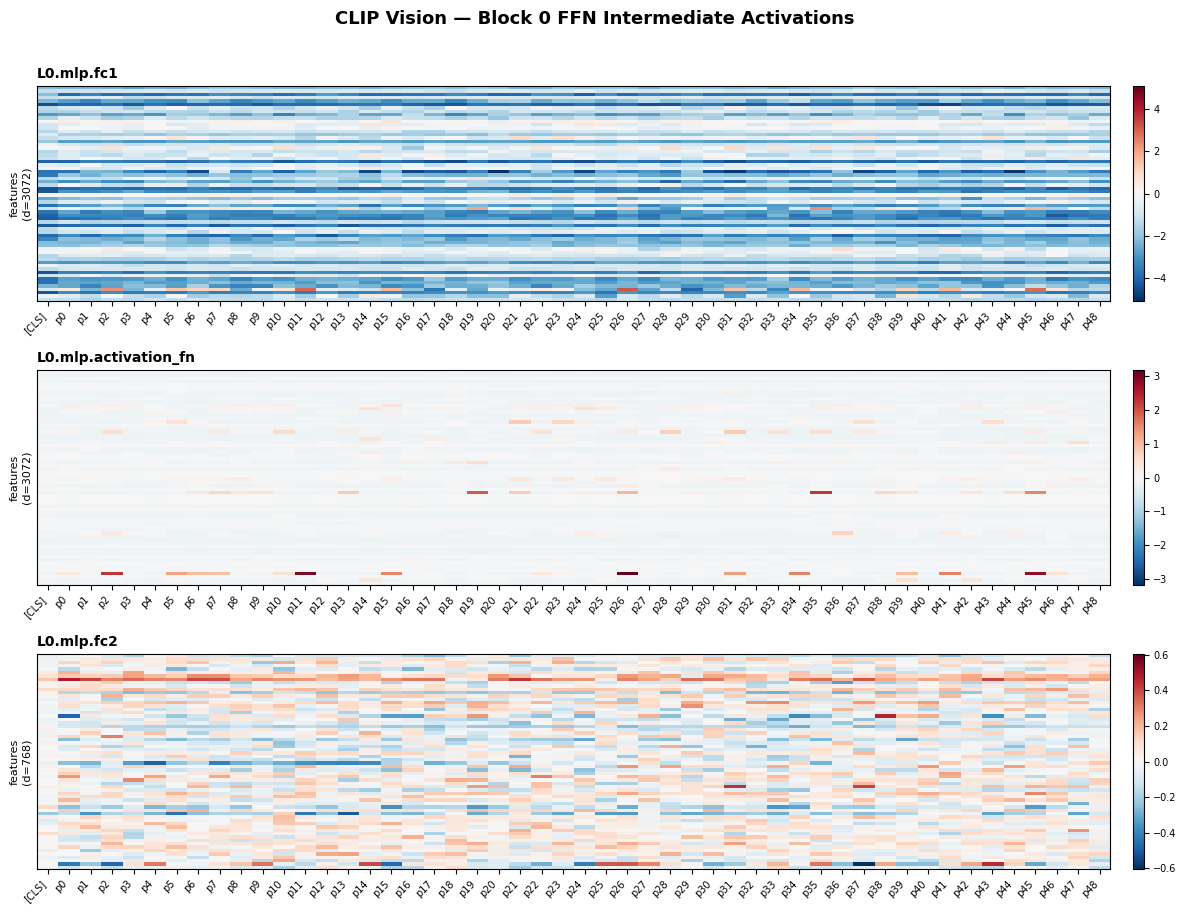

In [6]:
ffn_ids = ["L0.mlp.fc1", "L0.mlp.activation_fn", "L0.mlp.fc2"]
ffn_acts = accessor.get_multi_layer_activations(
    ffn_ids, pixel_values=pixel_values
)
print("Generating FFN activation heatmaps (block 0)...")
fig1 = visualize_activations(
    ffn_acts,
    tokens=patch_labels,
    title="CLIP Vision — Block 0 FFN Intermediate Activations",
    use_pyplot=False,
)

# 5. Visualization 2: Attention Q/K/V/Out projections (block 0)

Generating attention projection heatmaps (block 0)...


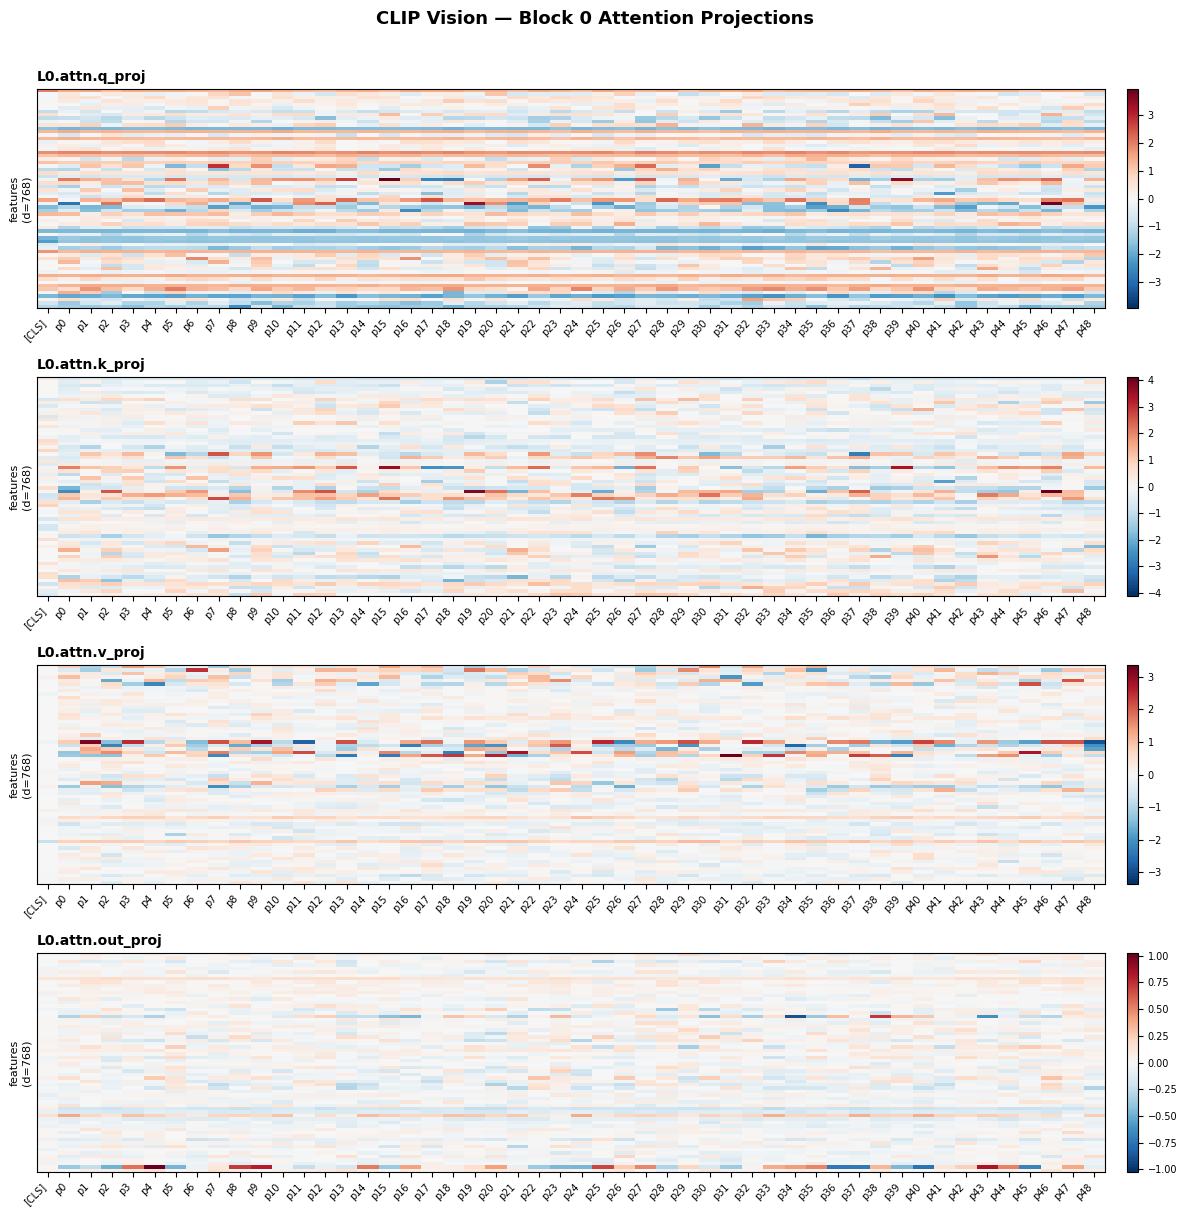

In [7]:
attn_ids = [
    "L0.attn.q_proj",
    "L0.attn.k_proj",
    "L0.attn.v_proj",
    "L0.attn.out_proj",
]
attn_acts = accessor.get_multi_layer_activations(
    attn_ids, pixel_values=pixel_values
)
print("Generating attention projection heatmaps (block 0)...")
fig2 = visualize_activations(
    attn_acts,
    tokens=patch_labels,
    title="CLIP Vision — Block 0 Attention Projections",
    use_pyplot=False,
)

# 6. Visualization 3: Per-token summary statistics (FFN block 0)

Generating per-patch FFN statistics (block 0)...


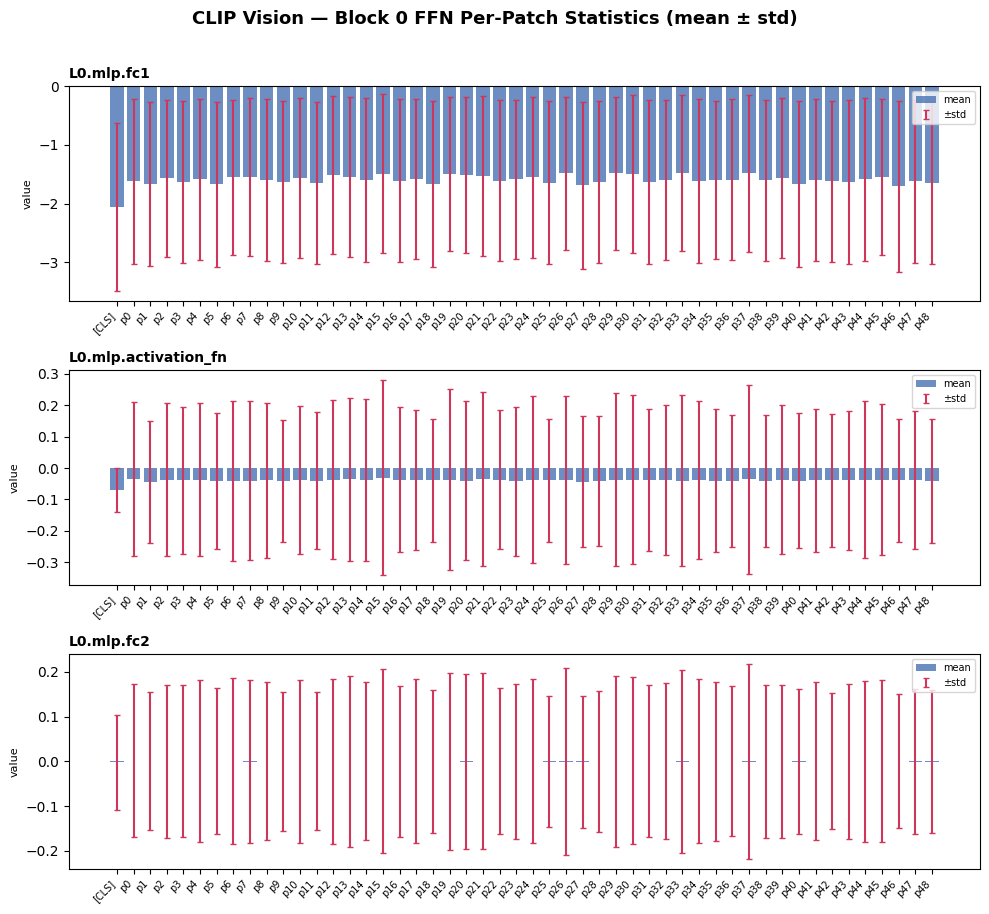

In [8]:
print("Generating per-patch FFN statistics (block 0)...")
fig3 = visualize_activation_stats(
    ffn_acts,
    tokens=patch_labels,
    title="CLIP Vision — Block 0 FFN Per-Patch Statistics (mean ± std)",
    use_pyplot=False,
)

# 7. Visualization 4: Activation distribution across layers
Compare QuickGELU output from early, mid, and late blocks.

Generating activation distribution plot...


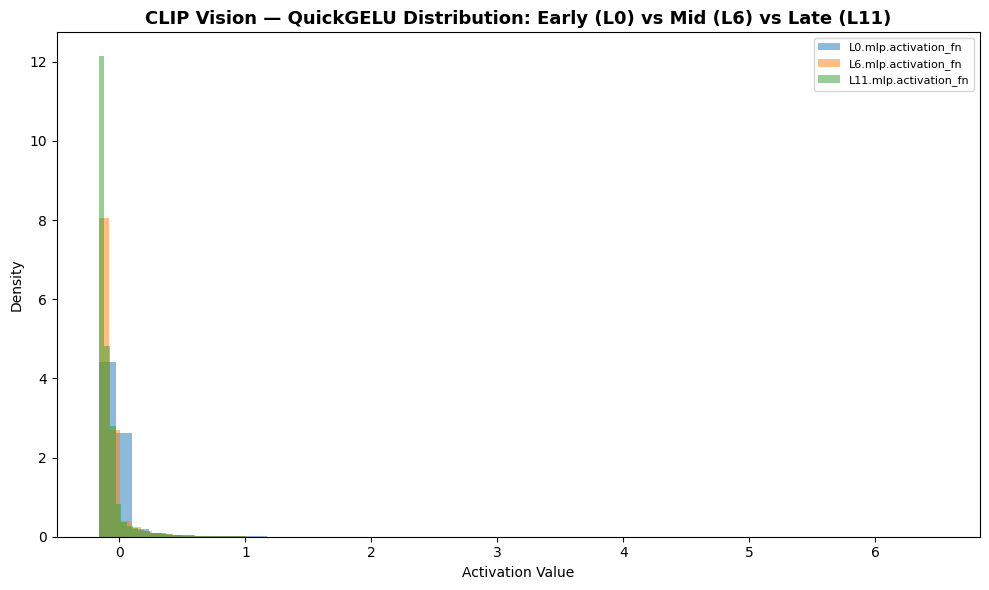

In [9]:
all_act_ids = [
    f"L{i}.mlp.activation_fn" for i in range(num_layers)
]
all_act_vals = accessor.get_multi_layer_activations(
    all_act_ids, pixel_values=pixel_values
)
mid = num_layers // 2
last = num_layers - 1
dist_acts = {
    f"L0.mlp.activation_fn": all_act_vals[f"L0.mlp.activation_fn"],
    f"L{mid}.mlp.activation_fn": all_act_vals[
        f"L{mid}.mlp.activation_fn"
    ],
    f"L{last}.mlp.activation_fn": all_act_vals[
        f"L{last}.mlp.activation_fn"
    ],
}
print("Generating activation distribution plot...")
fig4 = visualize_activation_distribution(
    dist_acts,
    title=(
        "CLIP Vision — QuickGELU Distribution: "
        f"Early (L0) vs Mid (L{mid}) vs Late (L{last})"
    ),
    use_pyplot=False,
)

# 8. Visualization 5: Attention heads — all heads in layer 0
The attention weight matrix has shape `(batch, num_heads, num_patches+1, num_patches+1)`.
Each cell $(i, j)$ shows how much patch $i$ attends to patch $j$.

Extracting attention weights for layer 0...
  Attention weights shape: torch.Size([1, 12, 50, 50])
Generating attention heatmaps (all heads, layer 0)...


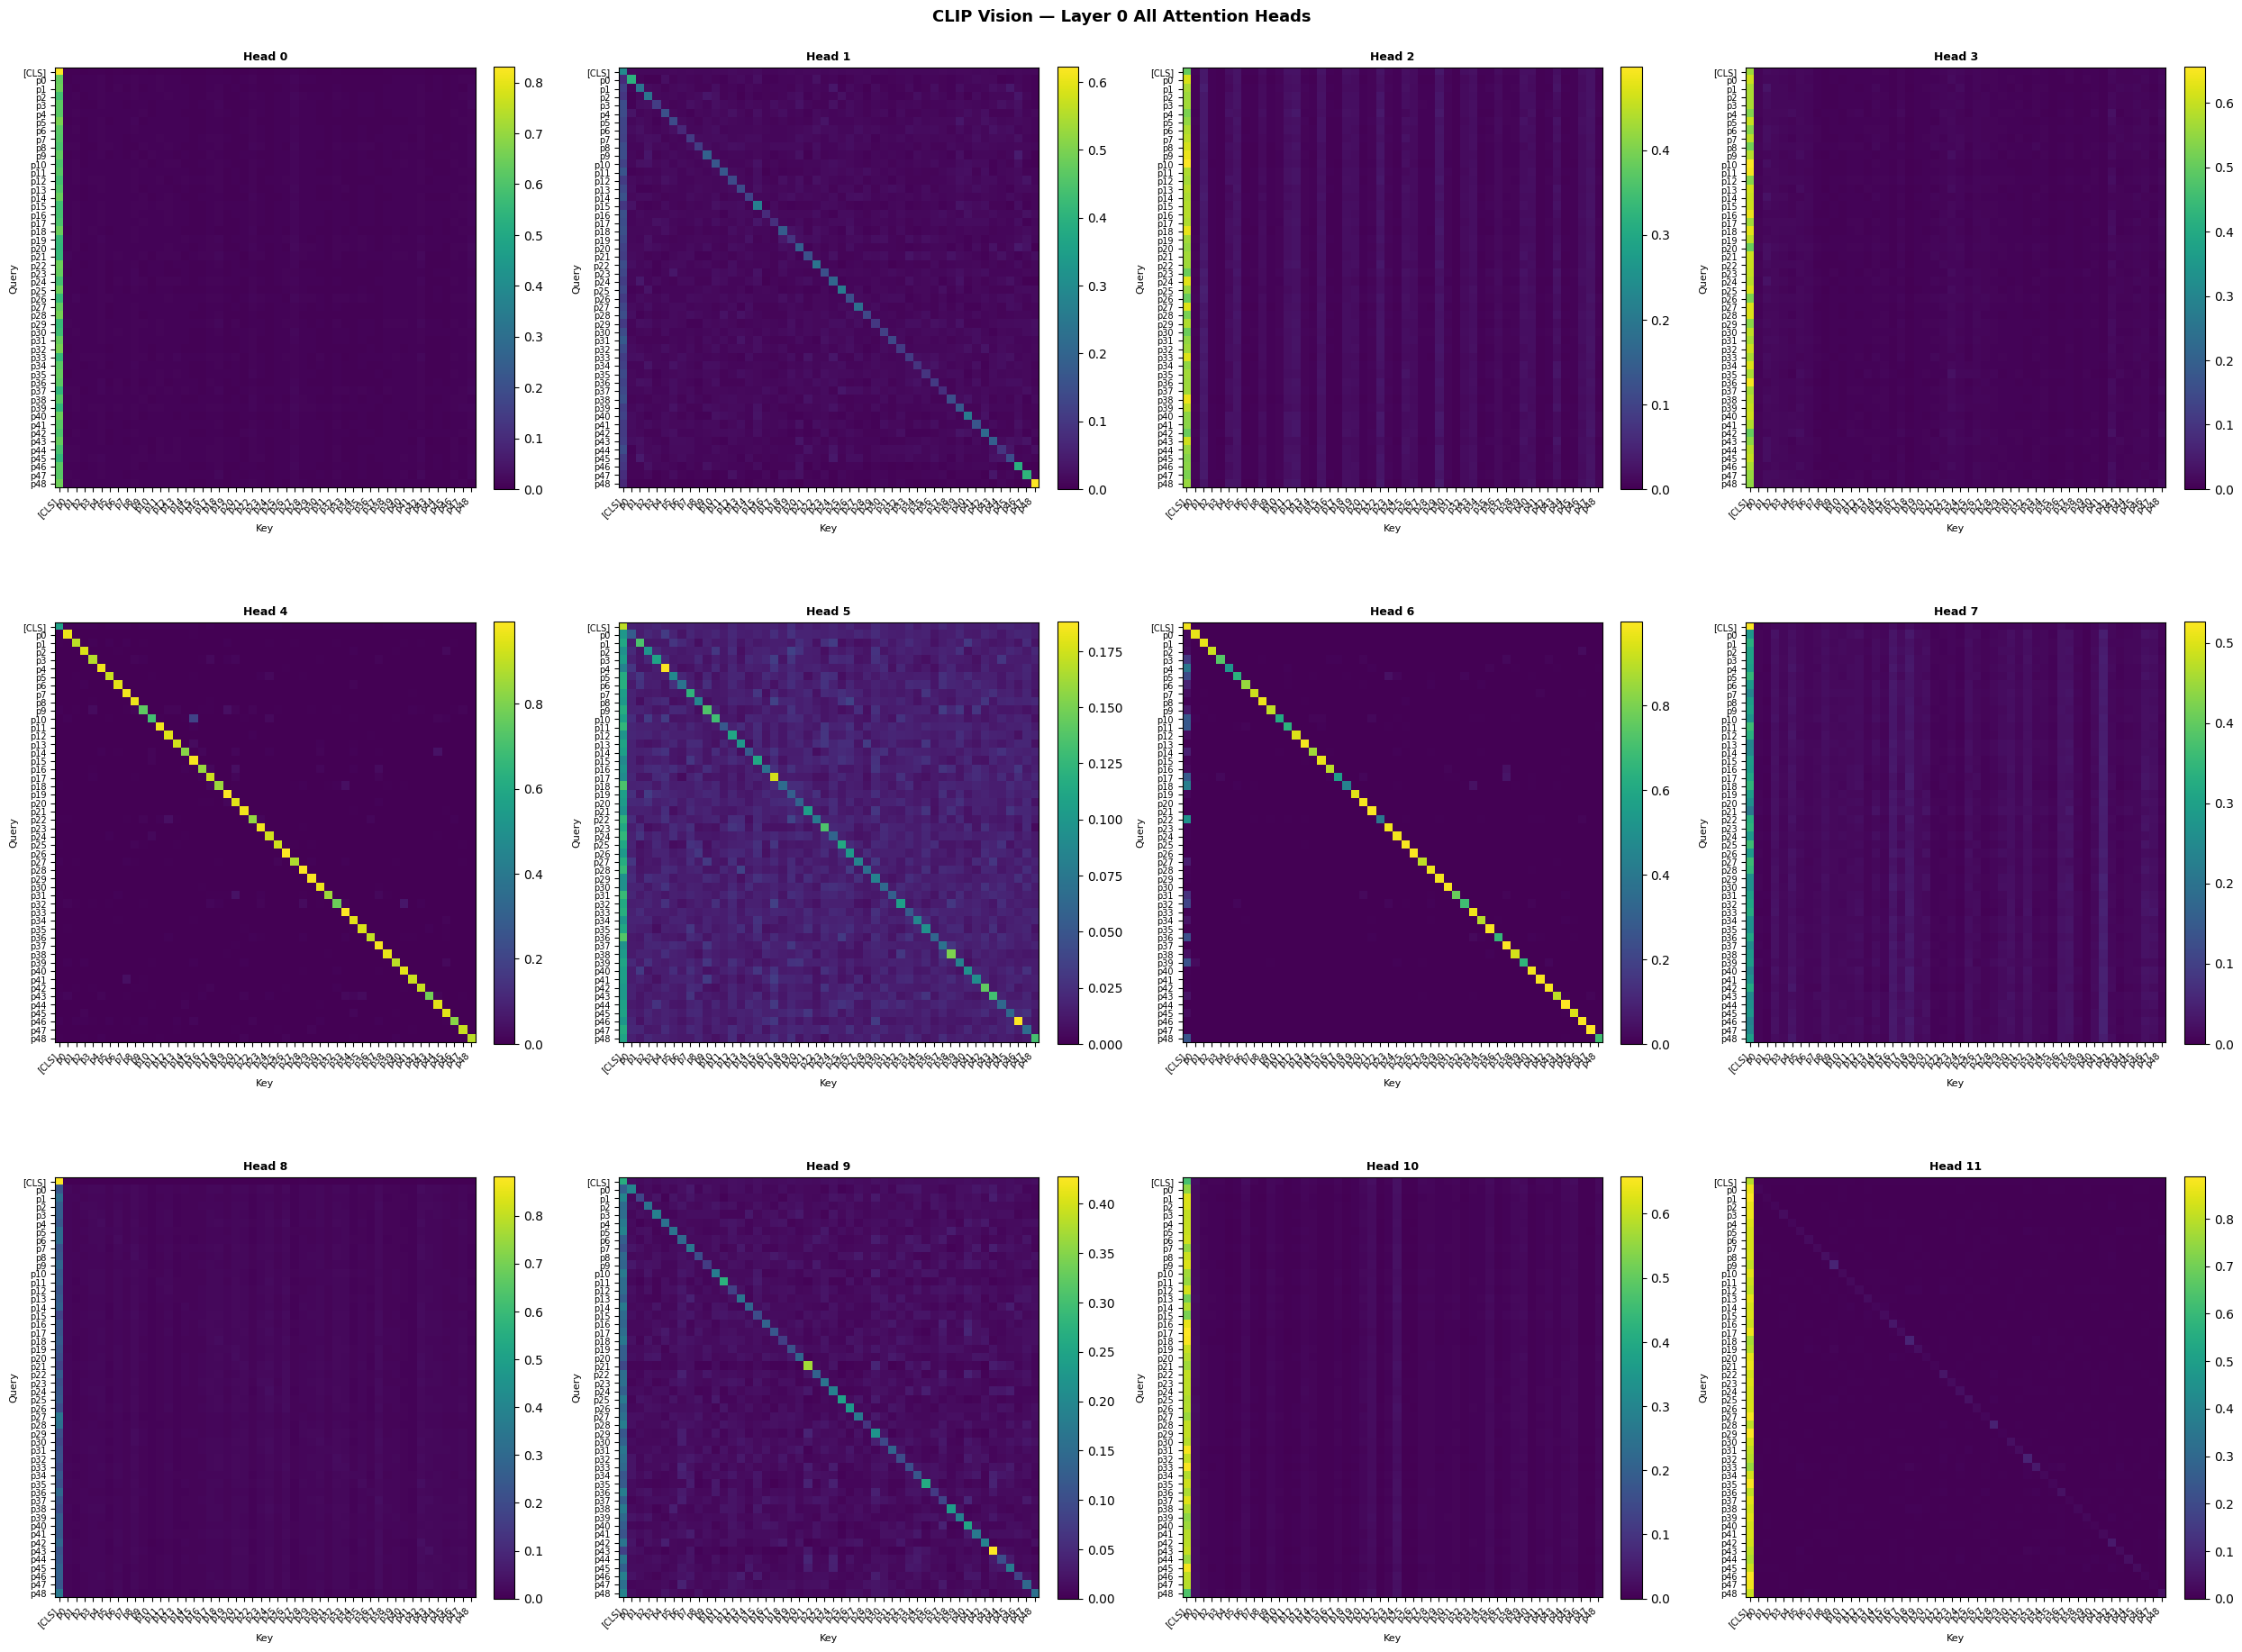

In [10]:
print("Extracting attention weights for layer 0...")
attn_weights = accessor.get_attention_weights(
    "L0", pixel_values=pixel_values, output_attentions=True
)
print(f"  Attention weights shape: {attn_weights.shape}")

print("Generating attention heatmaps (all heads, layer 0)...")
fig5 = visualize_attention_heads(
    attn_weights,
    tokens=patch_labels,
    title="CLIP Vision — Layer 0 All Attention Heads",
    use_pyplot=False,
)

# 9. Visualization 6: Attention head — single head (head 0)

Generating attention heatmap (head 0, layer 0)...


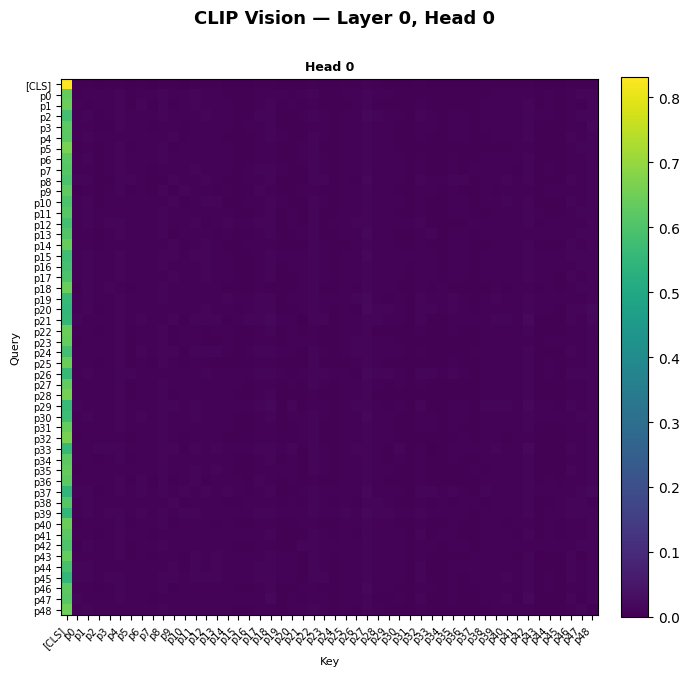

In [11]:
print("Generating attention heatmap (head 0, layer 0)...")
fig6 = visualize_attention_heads(
    attn_weights,
    head=0,
    tokens=patch_labels,
    show_values=False,
    title="CLIP Vision — Layer 0, Head 0",
    use_pyplot=False,
)

# 10. Visualization 7: Attention heads — selected subset

Generating attention heatmaps (heads [0, 6, 11], layer 0)...


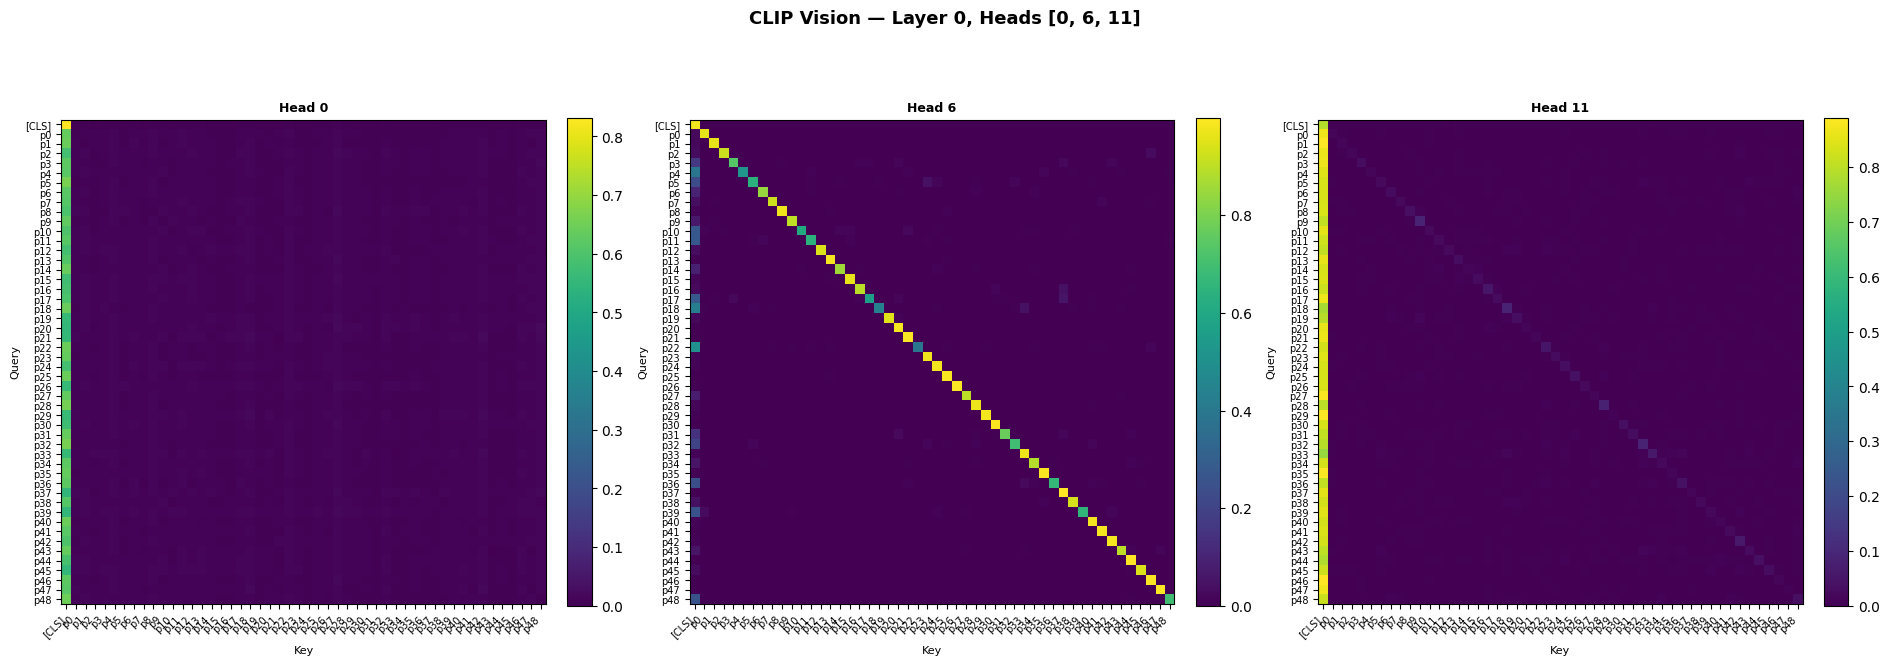

In [12]:
selected = [0, num_heads // 2, num_heads - 1]
print(
    f"Generating attention heatmaps (heads {selected}, layer 0)..."
)
fig7 = visualize_attention_heads(
    attn_weights,
    head=selected,
    tokens=patch_labels,
    title=f"CLIP Vision — Layer 0, Heads {selected}",
    use_pyplot=False,
)

# 11. Visualization 8: All-layer activation stats

Generating all-layer QuickGELU statistics...


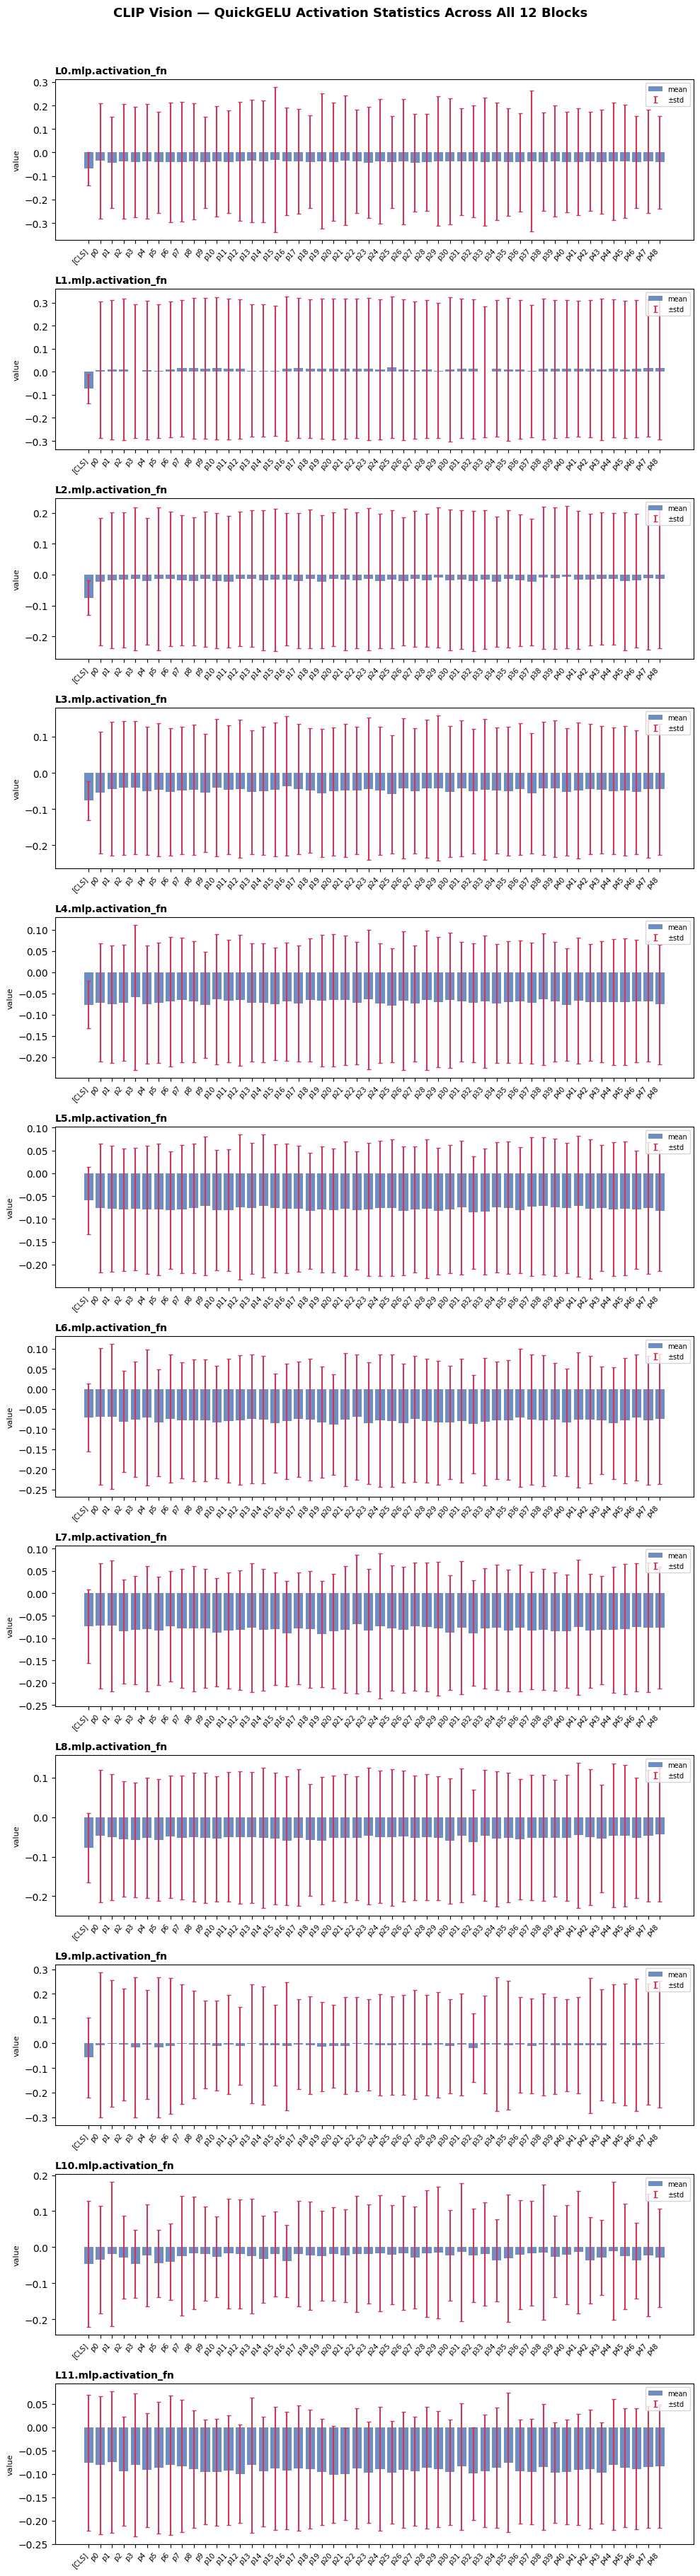

In [13]:
print("Generating all-layer QuickGELU statistics...")
fig8 = visualize_activation_stats(
    all_act_vals,
    tokens=patch_labels,
    title=(
        "CLIP Vision — QuickGELU Activation Statistics "
        f"Across All {num_layers} Blocks"
    ),
    use_pyplot=False,
)

In [14]:
print("\nDone! All vision encoder visualizations saved.")


Done! All vision encoder visualizations saved.
